In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('dataset/dataset_baru.csv',thousands=',')
df.dtypes

Book Tittle      object
Author           object
Rating          float64
Total Rating      int64
ScoreValue        int64
People Voted      int64
Pages             int64
                 object
Unnamed: 8      float64
Unnamed: 9      float64
Unnamed: 10      object
dtype: object

In [ ]:
df.drop(columns=['Total Rating', 'People Voted', ' ', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10','Author','Rating'], inplace=True)
df.head()

,Book Tittle,ScoreValue,Pages
0,The No. 1 Ladies' Detective Agency (No. 1 Ladi...,944,235
1,"A Long Time Dead (The Dead Trilogy, #1)",761,373
2,"No More Tears (The Dead Trilogy, #3)",748,519
3,"Stealing Elgar (The Dead Trilogy, #2)",658,652
4,The Dragonriders of Pern: Dragonflight / Drago...,754,832


In [ ]:
def generate_adj_mat_profit(df):
    profits = df['ScoreValue'].values
    datas2 = [[profits[i] + profits[j] if i!=j else 0 for j in range(len(profits))] for i in range(len(profits))]
    adj_mat_p = pd.DataFrame(datas2)
    return adj_mat_p

def generate_adj_mat_weight(df):
    weights = df['Pages'].values
    datas = [[weights[i] + weights[j] if i!=j else 0 for j in range(len(weights))] for i in range(len(weights))]
    adj_mat_w = pd.DataFrame(datas)
    return adj_mat_w

def generate_1_semut(ndim):
    return [[], list(range(ndim))]
 
def generate_individus(n_individu,ndim):
    return [generate_1_semut(ndim) for i in range(n_individu)]

def generate_pheromones(ndim,tau_awal):
    pheromones = np.ones(shape=(ndim,ndim)) * tau_awal
    np.fill_diagonal(pheromones,0)
    return pd.DataFrame(pheromones)

def generate_delta_pheromones(dim_semut):
    return generate_pheromones(dim_semut,0)

def trf_pilih(barang_dipilih,ndim):
    # semut[0] maksudnya elemen dari 1 semut yang visited / barang yang dipilih
    arr_kosong = list(map( lambda x:0 ,range(ndim))) # inisialisasi array kosong
   
    for i in range(len(barang_dipilih)):
        for j in range(len(arr_kosong)):
            if barang_dipilih[i]==j:
                arr_kosong[barang_dipilih[i]] = 1
    return arr_kosong

def f_obj(X,profits):
    return sum(map(lambda x,p: x*p, X, profits))

def f_con_w(X,weights,lim):
    ws = sum(map(lambda x,w: x*w, X, weights))
    return ws <= lim

def ro_1(el_c,el_t,pher,adj_mat,params):
    return ( pher.iloc[el_c,el_t] )**params['alpha'] * ( 1/adj_mat.iloc[el_c,el_t])**params['beta']

def ro_1_all(semut,pher,adj_mat,params):
    return [ ro_1(semut[0][-1],el_t,pher,adj_mat,params) for el_t in semut[1] ]

def transition_prob(semut,pher,adj_mat,params):
    pher = generate_pheromones(int(params['ndim']),params['tau_awal'])
    adj_mat = generate_adj_mat_profit(df)
    r = ro_1_all(semut,pher,adj_mat,params)
    total_prob = sum(r)
    return [p/total_prob for p in r]

def pilih_next_barang(semut,pher,adj_mat,params):
    df_prob = pd.DataFrame( {'next':semut[1] , 'prob':transition_prob(semut,pher,adj_mat,params) } )
    number = np.random.rand(1)
    if number > params['prob_pilih_barang']:
        choosen = df_prob.sample(n=1,weights='prob').iloc[0,0]
        return nv_to_v(semut,choosen)
    else:
        return semut

def pilih_next_barang_semua(semut,pher,adj_mat,params):
    return [pilih_next_barang(s,pher,adj_mat,params) for s in semut]

def update_delta_pheromones(semut,delta_pher,adj_mat,params):
    temp = generate_delta_pheromones(int(params['ndim']))
    for s in semut:
        Lk = f_obj(s[0],adj_mat)
        if len(s[0]) >= 2:
            temp.loc[ s[0][-2] ][ s[0][-1] ] = delta_pher[ s[0][-2] ][ s[0][-1] ] + (params['Q'] * Lk)
    return temp

def update_pheromones(pher,delta_pher,semut,adj_mat_p,params):
    return params['rho'] * pher + update_delta_pheromones(semut,delta_pher,adj_mat_p,params)

def sol(semut):
    return np.array([s[0] for s in semut])

def calc_fitness(X,adj_mat_p,adj_mat_w,lim): 
    return f_obj(X,adj_mat_p) if f_con_w(X,adj_mat_w,lim) else 0

def calc_fitness_all(semut,adj_mat_p,adj_mat_w,lim,ndim):
    return np.array([calc_fitness(trf_pilih(s,ndim),adj_mat_p,adj_mat_w,lim) for s in semut])

def find_best(sl,fitness):
    idxs = np.argsort(fitness)
    return np.append(sl[idxs][0],fitness[idxs][0])

def nv_to_v(semut,el):
    temp = semut.copy()
    temp[0].append(el)
    temp[1].remove(el)
    return temp

def initialization(semut):
    return [ nv_to_v(s,s[1][ np.random.randint(0,len(s[1]))] ) for s in semut ]

def satu_cycle(pheromones,adj_mat_p,adj_mat_w,params):
    semut = generate_individus(int(params['n_individu']),int(params['ndim']))
    semut = initialization(semut)
    delta_pheromones = generate_delta_pheromones(int(params['ndim']))
    
    t = 1
    while t < params['ndim']:
        semut = pilih_next_barang_semua(semut,pheromones.values,adj_mat_p,params)
        pheromones = update_pheromones(pheromones,delta_pheromones,semut,adj_mat_p,params)
        delta_pheromones = generate_delta_pheromones(int(params['ndim']))
        t += 1
    
    sl = sol(semut)
    fitness = calc_fitness_all(sl,adj_mat_p,adj_mat_w,params['lim'],int(params['ndim']))
    return find_best(sl,fitness),pheromones

def ACO(params,df):
    adj_mat_p = generate_adj_mat_profit(df)
    adj_mat_w = generate_adj_mat_weight(df)
    generasi = 0
    bests = []
    pheromones = generate_pheromones(int(params['ndim']),1)
    delta_pheromones = generate_delta_pheromones(int(params['ndim']))
    
    while generasi < params['max_generasi']:
        best,pheromones = satu_cycle(pheromones,adj_mat_p,adj_mat_w,params)
        bests.append(  trf_pilih(best[:-1].tolist(), int(params['ndim']) ) + [best.tolist()[-1] ])
        generasi += 1
        
    return pd.DataFrame(bests)

def run_ACO(dfparams,df):
    return[ACO(dfparams.loc[i].to_dict(),df) for i in range(dfparams.shape[0])]

def save_ACO(hasils):
    for h in enumerate(hasils):
        pd.DataFrame(h[1]).to_csv('dataset/hasil_params11/ulang5/ACO_hasil' + str(h[0]) + '.csv')

In [ ]:
prof = df['ScoreValue'].values

params = {
    'alpha': 1,
    'beta': 1,
    'rho': 0.8,
    'Q': 1,
    'n_individu':10,
    'ndim':len(prof),
    'lim':40000,
    'prob_pilih_barang':0.5,
    'tau_awal':1,
    'max_generasi':5
}

hasil = ACO(params,df)
df_hasil = pd.DataFrame(hasil)

<ipython-input-427-02f12cf07baa>:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([s[0] for s in semut])
<ipython-input-427-02f12cf07baa>:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([s[0] for s in semut])
<ipython-input-427-02f12cf07baa>:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return 

In [ ]:
df_hasil

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,1,1,1,0,0,1,1,1,...,0,0,0,0,1,1,0,0,0,1816
1,1,1,0,0,1,0,1,0,1,0,...,1,0,0,0,0,1,0,0,1,1950
2,1,1,1,1,0,1,0,1,0,0,...,1,0,0,1,0,1,1,0,0,2162
3,1,1,1,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,1955
4,0,0,1,0,1,1,1,0,0,1,...,1,0,0,0,1,0,1,0,1,2169


In [ ]:
df_hasil.iloc[4,:99].where(lambda x: x>0).count()

48

Artinya ada 48 barang yang dipilih oleh generasi yang memiliki profit yang paling terbaik di antara generasi semut yang lain

In [ ]:
#dfparams = pd.read_csv('dataset/ACO_params13.csv')
#hasils = run_ACO(dfparams,df)

In [ ]:
#save_ACO(hasils)

In [ ]:
df_alpha_beta = pd.read_csv('dataset/hasil_alpha_beta.csv')
df_rho = pd.read_csv('dataset/hasil_rho.csv')
df_populasi = pd.read_csv('dataset/hasil_semut.csv')
df_q = pd.read_csv('dataset/hasil_Q.csv')
df_tau = pd.read_csv('dataset/hasil_tau.csv')
df_tau.head()

,0.1,1,2
0,2254,2078,2139
1,2017,2157,1844
2,2084,2129,2080
3,2234,2170,2164
4,2098,2074,2220


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hasil Analisis Parameter Alpha dan Beta

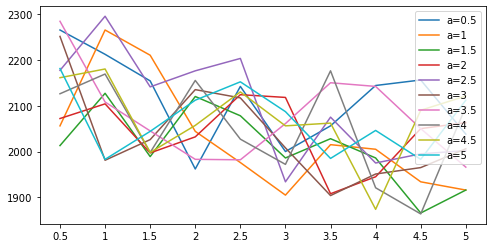

In [ ]:
labels=['a=0.5','a=1','a=1.5','a=2','a=2.5','a=3','a=3.5','a=4','a=4.5','a=5']

fig = plt.figure(figsize=(8, 4))

x_a_b = list(df_alpha_beta.columns.values)
for i in range(len(df_alpha_beta)):
    plt.plot(x_a_b,df_alpha_beta.loc[i],label=labels[i])

plt.legend()
plt.show()

Recommended: 
- b = 1, 2, 2.5, 3.5
- a = 2.5

Analisis: 
1. Semakin tinggi nilai beta, maka semakin menjauhi global optimum
2. Nilai beta yang memiliki profit yang cukup baik untuk nilai alpha berapapun ada di angka 1
3. Untuk nilai alpha yang memiliki profit yang cukup baik ada di angka 2.5

# Hasil Analisis Parameter Rho 

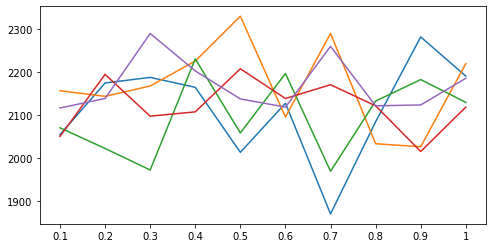

In [ ]:
fig = plt.figure(figsize=(8, 4))
x_rho = list(df_rho.columns.values)
for i in range(len(df_rho)):
    plt.plot(x_rho,df_rho.loc[i])
plt.show()

- biru: ulang1
- oren: ulang2
- hijau: ulang3
- merah: ulang4
- ungu: ulang5

Recommended: 0.2, 0.4, 0.5, 0.6

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


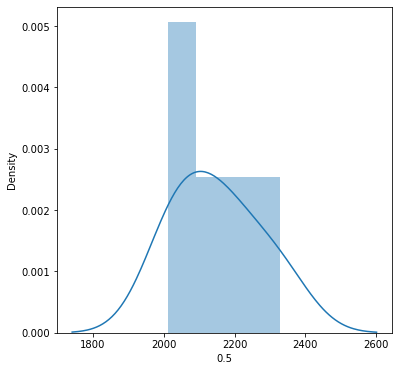

In [ ]:
plt.figure(figsize=(6, 6))
sns.distplot(df_rho['0.5'], bins=4);

# Hasil Analisis Parameter Jumlah Semut 

 Ketika:
 - a = 2.5
 - b = 1
 - rho = 0.5
 - tau_awal = 1
 - max_generasi = 5

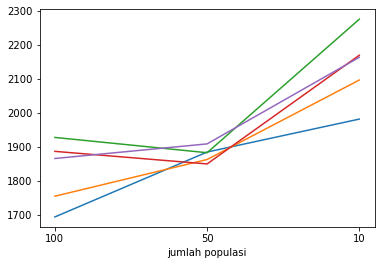

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
x_pop = list(df_populasi.columns.values)
for i in range(len(df_populasi)):
    plt.plot(x_pop,df_populasi.loc[i])
ax.set(xlabel='jumlah populasi')
plt.show()

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

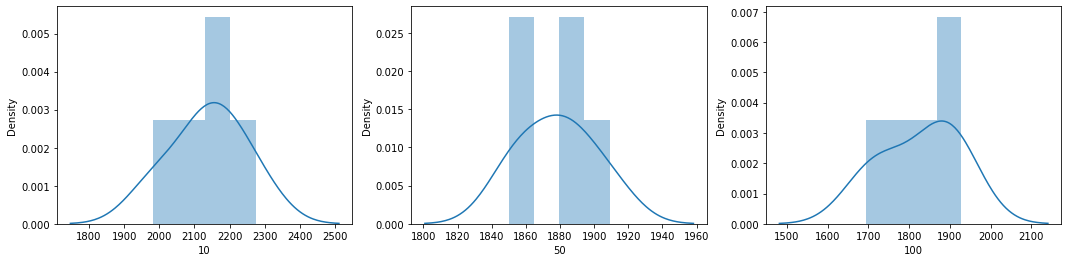

In [ ]:
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1)
sns.distplot(df_populasi['10'], bins=4);

plt.subplot(1,3,2)
sns.distplot(df_populasi['50'], bins=4);

plt.subplot(1,3,3)
sns.distplot(df_populasi['100'], bins=4);

Recommended: n_populasi = 10

# Hasil Analisis Parameter Q 

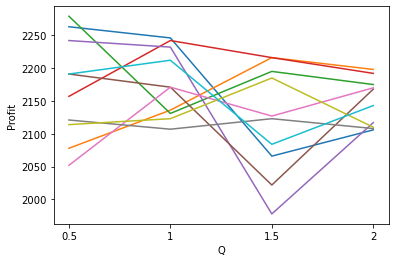

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
x_q = list(df_q.columns.values)
for i in range(len(df_q)):
    plt.plot(x_q,df_q.loc[i])
ax.set(xlabel='Q',ylabel='Profit')
plt.show()

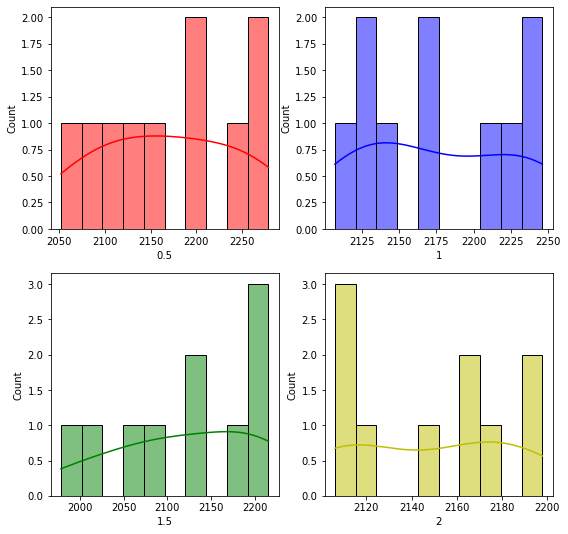

In [ ]:
plt.figure(figsize=(9, 9))

plt.subplot(2,2,1)
sns.histplot(df_q['0.5'],color='r', bins=10, stat="count",kde=True);

plt.subplot(2,2,2)
sns.histplot(df_q['1'],color='b', bins=10, stat="count", kde=True);

plt.subplot(2,2,3)
sns.histplot(df_q['1.5'],color='g', bins=10, stat="count", kde=True);

plt.subplot(2,2,4)
sns.histplot(df_q['2'],color='y', bins=10, stat="count", kde=True);

Recommended: Q = 1

# Hasil Analisis Parameter Tau 

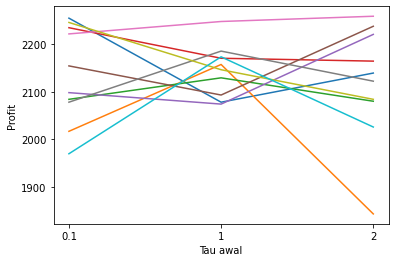

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
x_tau = list(df_tau.columns.values)
for i in range(len(df_tau)):
    plt.plot(x_tau,df_tau.loc[i])
ax.set(xlabel='Tau awal',ylabel='Profit')
plt.show()

Recommended: tau_awal = 1

# Hasil Terbaik 

In [ ]:
df_best = pd.read_csv('dataset/hasil_params10/ulang2/ACO_hasil4.csv')
df_best.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
df_best

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1,1,0,0,1,1,1,1,0,0,...,0,0,1,0,1,1,0,0,1,2026
1,0,1,1,1,1,1,1,1,0,0,...,1,0,0,0,0,1,0,0,0,2329
2,1,0,1,1,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,2153
3,1,1,1,1,1,0,0,1,1,1,...,0,1,0,0,0,0,1,0,0,2134
4,0,0,1,0,1,1,0,1,0,0,...,1,0,0,0,0,0,1,0,0,2003


In [ ]:
df_best.iloc[1,:99].where(lambda x: x>0).count()

55

Hasil profit/fitness yang didapat menyentuh di angka 2329 dan buku yang diambil total berjumlah 44 buku